In [2]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Contextual embeddings

In [3]:
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-mpnet-base-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-mpnet-base-v2")

In [4]:
sentence_a = "I want a recipe with tomato"
sentence_b = "tomato recipe"
inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True, max_length = 512, truncation = True)

input_ids = inputs['input_ids']
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)

In [5]:
with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True, output_attentions=True)

attention = outputs.attentions
hidden_states = outputs.hidden_states

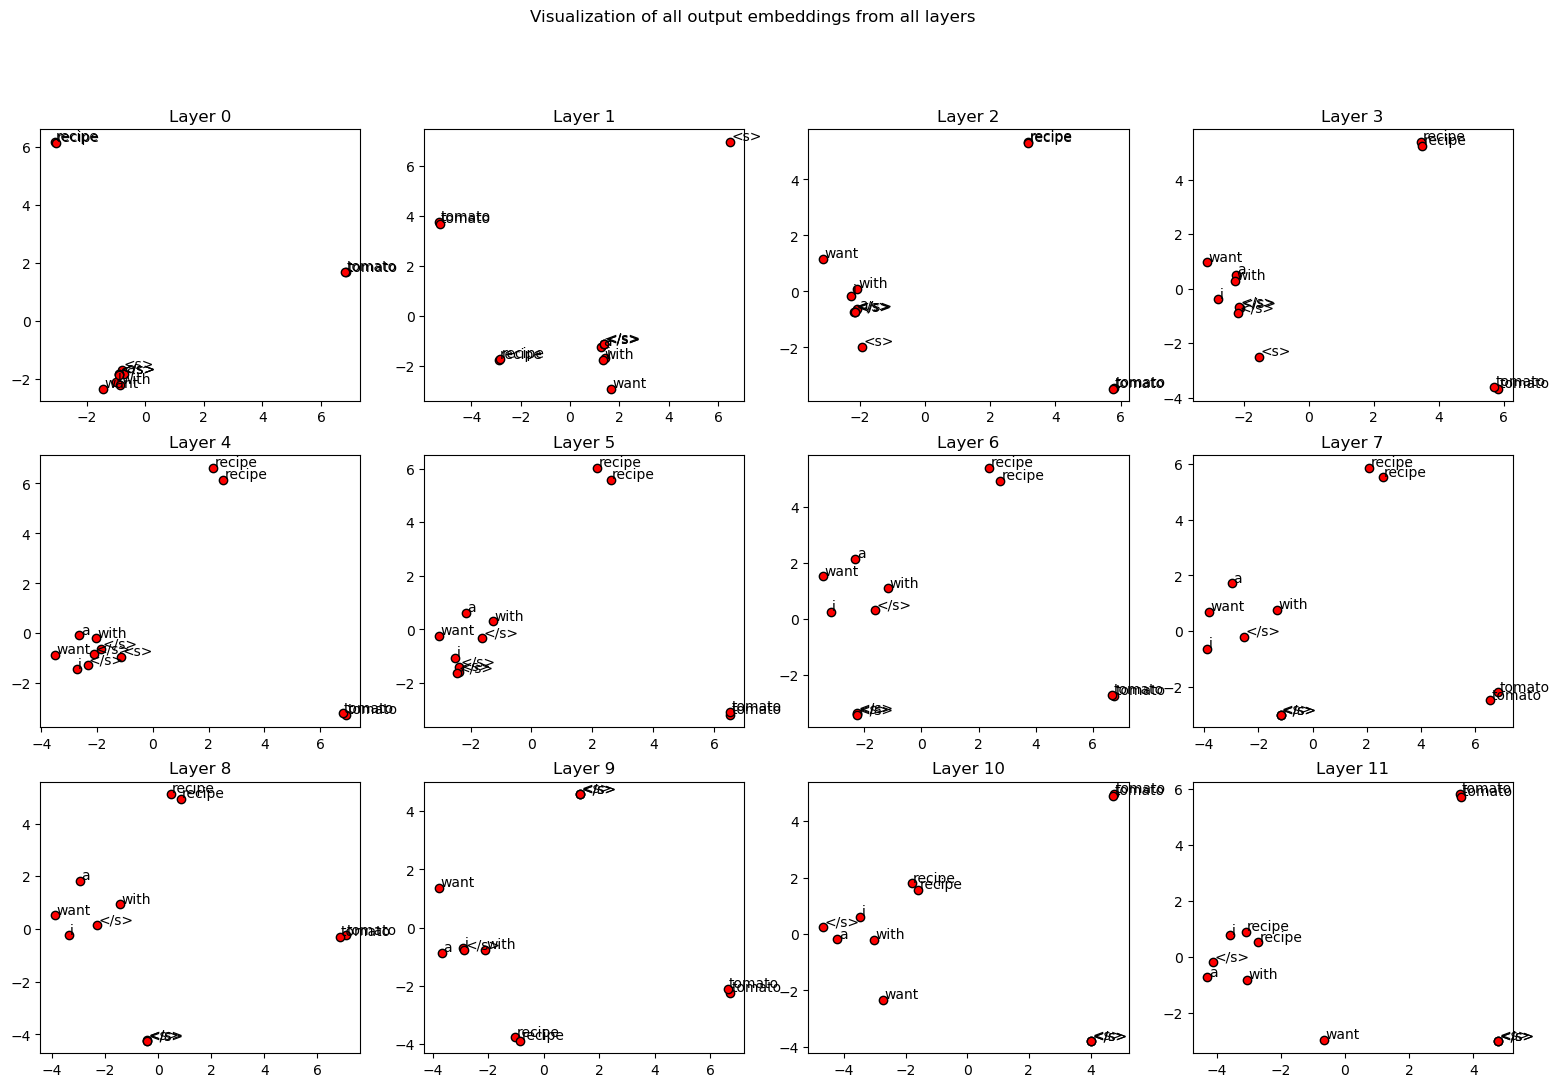

In [6]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

layer = 1

rows = 3
cols = 4
fig, ax_full = plt.subplots(rows, cols)
fig.set_figheight(rows*4)
fig.set_figwidth(cols*4+3)
plt.rcParams.update({'font.size': 6})


layer = 0
for r in range(rows):
    for c in range(cols):
       
        ax = ax_full[r,c]
        
        plt.rcParams.update({'font.size': 10})
        current_hidden_state = hidden_states[layer][0].detach().numpy()
        
        if current_hidden_state.shape[1] == 2:
            twodim = current_hidden_state
        else:
            twodim = PCA().fit_transform(current_hidden_state)[:,:2]

        plt.style.use('default') # https://matplotlib.org/3.5.1/gallery/style_sheets/style_sheets_reference.html
        im = ax.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
        for word, (x,y) in zip(tokens, twodim):
            ax.text(x+0.05, y+0.05, word)
        
        # Show all ticks and label them with the respective list entries
        ax.set_title("Layer " + str(layer))
            
        # Loop over data dimensions and create text annotations.
        layer = layer + 1

fig.suptitle("Visualization of all output embeddings from all layers")
plt.show()

# Positional Embeddings

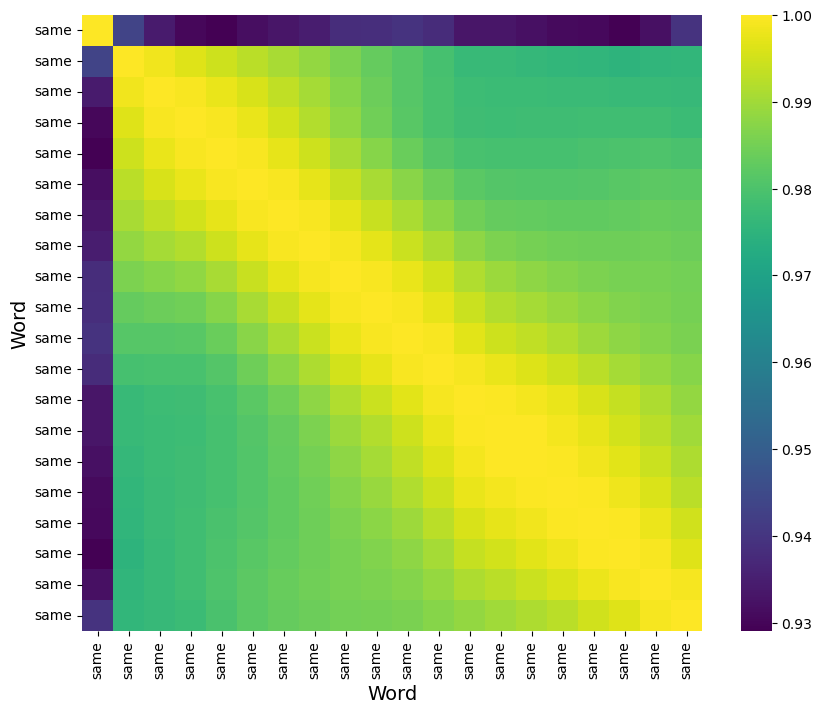

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from transformers import BertModel, BertTokenizer
from sklearn.metrics.pairwise import cosine_similarity

# Load pre-trained BERT model and tokenizer
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# Choose a token to visualize its positional embeddings
token = ["same"]*20
token_ids = tokenizer.encode(token, add_special_tokens=False, return_tensors="pt")[0]

# Prepare input for the model
input_ids = token_ids.unsqueeze(0)  # Add batch dimension

# Get positional embeddings from the BERT model
with torch.no_grad():
    outputs = model(input_ids)
    embeddings = outputs[0][0].numpy()  # shape: (seq_len, hidden_dim)

# Compute cosine similarity between word embeddings
similarity_matrix = cosine_similarity(embeddings)

# Prepare words for y-axis
words = [tokenizer.decode([id]) for id in token_ids]

# Plot similarity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, cmap="viridis", yticklabels=words, xticklabels=words)
plt.xlabel("Word", fontsize=14)
plt.ylabel("Word", fontsize=14)
#plt.title(f"Similarity Matrix for token '{token}'", fontsize=16)
plt.show()


# Self-Attention

### Cross encoder

In [8]:
# From transformers.

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
import torch

# cross-encoder/ms-marco-MiniLM-L-12-v2
model = AutoModelForSequenceClassification.from_pretrained('cross-encoder/ms-marco-MiniLM-L-12-v2')
tokenizer = AutoTokenizer.from_pretrained('cross-encoder/ms-marco-MiniLM-L-12-v2')

pipe = pipeline("text-classification", model=model, tokenizer=tokenizer)


pipe([{"text": "How to make pasta?", "text_pair": "How much does 1KG of pasta costs?"}])

[{'label': 'LABEL_0', 'score': 0.0010675573721528053}]

### Dual encoder

In [16]:
# tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/msmarco-distilbert-base-v2")
# model = AutoModel.from_pretrained("sentence-transformers/msmarco-distilbert-base-v2")

sentence_a = "How to make pasta?"
sentence_b = "How much 1KG of pasta costs?"

input_a = tokenizer(sentence_a, return_tensors="pt")
input_b = tokenizer(sentence_b, return_tensors="pt")

with torch.no_grad():
    scores_a = model(**input_a)
    scores_b = model(**input_b)

similarity_score = cosine_similarity(scores_a.logits, scores_b.logits)

print(similarity_score.item())

1.0
